# Junior Doctor Joins the Scottish Deanery


![](https://www.scotlanddeanery.nhs.scot/media/398547/deanerymap_v1_regions-01-002.png?width=662&height=372)


### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://scottish-deanery-agent:3021 and an api key of DeaneryAPIKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and fill in additional logic as needed.

In [4]:
listeners = []

In [5]:
## YOUR LISTENERS HERE
# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")
    if state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)

In [6]:
def issuer_handler(payload):
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    
    
    if state == "offer_sent":
        proposal = payload["credential_proposal_dict"]
        attributes = proposal['credential_proposal']['attributes']

        print(f"Offering credential with attributes  : {attributes}")
        ## YOUR LOGIC HERE
    elif state == "request_received":
        print("Request for credential received")
        ## YOUR LOGIC HERE
    elif state == "credential_sent":
        print("Credential Sent")
        ## YOUR LOGIC HERE
    
issuer_listener = {
    "topic": "issue_credential",
    "handler": issuer_handler
}

listeners.append(issuer_listener)

In [7]:

def verifier_proof_handler(payload):
    role = payload["role"]
    connection_id = payload["connection_id"]
    pres_ex_id = payload["presentation_exchange_id"]
    state = payload["state"]
    print("\n---------------------------------------------------------------------\n")
    print("Handle present-proof")
    print("Connection ID : ", connection_id)
    print("Presentation Exchange ID : ", pres_ex_id)
    print("Protocol State : ", state)
    print("Agent Role : ", role)
    print("Initiator : ", payload["initiator"])
    print("\n---------------------------------------------------------------------\n")
    

    if state == "request_sent":
        print("Presentation Request\n")
        print(payload["presentation_request"])
        print("\nThe presentation request is encoded in base64 and packaged into a DIDComm Message\n")
        print(payload["presentation_request_dict"])
        print("\nNote the type defines the protocol present-proof and the message request-presentation\n")
        print(payload["presentation_request_dict"]["@type"])
    elif state == "presentation_received":
        print("Presentation Received")
        print("We will not go into detail on this payload as it is comparable to the presentation_sent we looked at in the earlier cell.")
    elif state == "verified":
        print("Presentation has been checked")
        print("Is Verified ? ", payload["verified"])
        
verifier_listener = {
    "topic": "present_proof",
    "handler": verifier_proof_handler
}

listeners.append(verifier_listener)

In [8]:
agent_controller.register_listeners(listeners)

## Store Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [ ]:
rtw_schema_id = 'UBDzYmydH198hgQq6yRyFu:2:UK Right to Work:0.0.1'
rtw_cred_def_id = 'UBDzYmydH198hgQq6yRyFu:3:CL:29:doctor-onboarding'
dbs_schema_id = 'UBDzYmydH198hgQq6yRyFu:2:DBS Check:0.0.1'
dbs_cred_def_id = 'UBDzYmydH198hgQq6yRyFu:3:CL:30:doctor-onboarding'
ic_schema_id = 'UBDzYmydH198hgQq6yRyFu:2:Immunity Certificate:0.0.1'
ic_cred_def_id = 'UBDzYmydH198hgQq6yRyFu:3:CL:31:doctor-onboarding'
cbt_schema_id = 'UBDzYmydH198hgQq6yRyFu:2:Compulsory Basic Training:0.0.1'
cbt_cred_def_id = 'UBDzYmydH198hgQq6yRyFu:3:CL:32:doctor-onboarding'



## Before Joining the Scottish Deanery the Doctor Must Demonstrate they Have a GMC Licence

The deanery challenges them with the following proof request

In [15]:
import time
# The GMC is the only entity able to issue GMC licences in the UK Healthcare system
gmc_schema_id = 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.2'

gmc_issuer_did = "TDAbSf3Uqebg8N4XvybMbg"

# cred_def_id = "<SOME CRED DEF>"

# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "Base64Image", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
    {"name": "Name", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
    {"name": "GMC Number", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
]

# We could extend this to request the name attribute aswell if we wanted.


gmc_licence_proof_request = {
    "name": "Proof of GMC Licence",
    "version": "1.0",
    "requested_attributes": {
        # They must follow this uuid pattern
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"{req_attr['name']}":
        req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
#     "non_revoked":  {"to": int(time.time())}
}

## Establish Connection

Before you can issue a credential you must first establish a connection across which the credential will be issued to a holder. (see recipes/connection)

In [10]:
# Alias for invited connection
alias = "Junior Doctor"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  525b8aa6-0276-4d28-9d6b-7d1b42003d21
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Share Invitation Object with External Agent

In [11]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'df28fb0c-b551-45ff-bf1c-1bc912f308ed', 'recipientKeys': ['7tFfaCBc3TK13be9SZSKPTUbyPvhk83SbxGFkCW76LKV'], 'label': 'Scottish Deanery', 'serviceEndpoint': 'https://d90661b25a39.ngrok.io'}
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  525b8aa6-0276-4d28-9d6b-7d1b42003d21
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  525b8aa6-0276-4d28-9d6b-7d1b42003d21
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  525b8aa6-0276-4d28-9d6b-7d1b42003d21
State :  active
Routing State :  none
Their Rol

## Display Invite as QR Code

This is useful if you wish to issue a credential to a mobile wallet.

In [ ]:
import qrcode
# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Request Proof of GMC Licence

In [16]:
proof_request = {
    "comment": "Please prove you have a GMC Licence",
    "connection_id": connection_id,
    "proof_request": gmc_licence_proof_request,
    # Do you want your agent to trace this request (for debugging)
    "trace": True
}

proof_request_response = await agent_controller.proofs.send_request(proof_request)


---------------------------------------------------------------------

Handle present-proof
Connection ID :  525b8aa6-0276-4d28-9d6b-7d1b42003d21
Presentation Exchange ID :  fc765e15-f1b5-4c88-88f6-d7b1eb02612e
Protocol State :  request_sent
Agent Role :  verifier
Initiator :  self

---------------------------------------------------------------------

Presentation Request

{'name': 'Proof of GMC Licence', 'version': '1.0', 'requested_attributes': {'Base64Image': {'name': 'Base64Image', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.2', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {'to': 1624471942}}, 'Name': {'name': 'Name', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.2', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {'to': 1624471942}}, 'GMC Number': {'name': 'GMC Number', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.2', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {

## Get Presentation Exchange Record

This record keeps track of the current state of the presentation protocol, which must be in the `presentation_received` state before the presentation can be verified.

Note: This could also happen in the webhook logic.

In [17]:
response = await agent_controller.proofs.get_records(state="presentation_received")
record = response["results"][0]
presentation_exchange_id = record["presentation_exchange_id"]

IndexError: list index out of range

## Verify Presentation



In [ ]:
verified_response = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

verified = verified_response["verified"]

## Check Attributes

In [ ]:
import base64
if verified == "true":
    for (name, val) in verified_response['presentation']['requested_proof']['revealed_attrs'].items():
        ## This is the actual data that you want. It's a little hidden
    #     print("Attribute : ", val)


        if name == "Base64Image":
            try:
                f = open("doctor-image.jpg", "wb+")
                base64_img_str = val['raw']
                b64_encoded = base64_img_str.encode('utf-8')
                decoded_img_data = base64.decodebytes(b64_encoded)
                f.write(decoded_img_data)
                f.close()
    #             base64_img_bytes = attribute["value"].encode('utf-8')
    #             decoded_img_data = base64.decodebytes(base64_img_bytes)

            except Exception as e:
                print("Error writing file", e)
        else:
            print(f"Attribute Name {name} Raw Value : {val['raw']}")

In [ ]:
from IPython.display import Image
Image("doctor-image.jpg")

![](https://dis-blog.thalesgroup.com/wp-content/uploads/2017/01/ID-Verification-banks.png)

# Perform Right to Work Check

## Provide Digital Evidence of Right to Work Check

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [ ]:
from datetime import date

status="UK Citizen"
date_completed=date.today().isoformat()
exp_date="N/A"
credential_attributes = [
    {"name": "Residency Status", "value": status},
    {"name": "Date Completed", "value": date_completed},
    {"name": "Expiration Date", "value": exp_date}
]
print(credential_attributes)

## Send Credential


In [ ]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = False
comment = ""
# Remove credential record after issued?
auto_remove = True

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, rtw_schema_id, rtw_cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)

# Perform DBS Check

![](https://checkback.co.uk/wp-content/uploads/2020/08/dbschecks.png)

## Provide Digital Evidence of DBS Check

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [ ]:
from datetime import date, timedelta
attributes = ["Certificate Reference Number","Date Completed", "Expiration Date", "Type"]

ref_no = "12343122"
status="UK Citizen"
date_completed=date.today().isoformat()
exp_date=(date.today() + timedelta(days=730)).isoformat()
credential_attributes = [
    {"name": "Certificate Reference Number", "value": status},
    {"name": "Date Completed", "value": date_completed},
    {"name": "Expiration Date", "value": exp_date},
    {"name": "Type", "value": "Basic"}
]
print(credential_attributes)

## Send Credential


In [ ]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = False
comment = ""
# Remove credential record after issued?
auto_remove = True

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, dbs_schema_id, dbs_cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)

# Complete Immunisations

![](https://qcs-qualitycomplianc.netdna-ssl.com/wp-content/uploads/2015/10/Immunisation-of-personel-in-the-workplaceR.jpg)

## Provide Immunity Certificate

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [ ]:
from datetime import date
import json


immunisations = {"covid" : True}

immJson = json.dumps(immunisations)
date_completed=date.today().isoformat()
credential_attributes = [
    {"name": "Immunisations", "value": immJson},
    {"name": "Date Completed", "value": date_completed},
]
print(credential_attributes)

## Send Credential


In [ ]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = False
comment = ""
# Remove credential record after issued?
auto_remove = True

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, ic_schema_id, ic_cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)

# Run Compulsory Basic Training

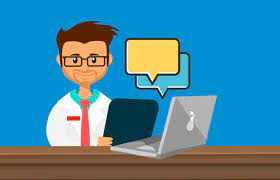

## Provide Digital Evidence of CBT

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [ ]:

date_completed=date.today().isoformat()
exp_date=(date.today() + timedelta(days=730)).isoformat()
credential_attributes = [
    {"name": "Date Completed", "value": date_completed},
    {"name": "Expiration Date", "value": exp_date}
]
print(credential_attributes)

## Send Credential


In [ ]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = False
comment = ""
# Remove credential record after issued?
auto_remove = True

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, cbt_schema_id, cbt_cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [ ]:
await agent_controller.terminate()